In [1]:
#Все необходимые библиотеки
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch as th

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm

import glob
import re

import time

from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\uljah\anaconda3\envs\NeuralNetw38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, is_valid):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.is_valid = is_valid
        
        if self.is_valid == 1:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
        else:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
            
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.frame[self.id_col].iloc[idx]
        img = os.path.join (self.path_imgs, img_name +'.jpg')

        image1 = Image.open(img)
        image = self.aug(image1)

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)

        return image, feats, label
    
# Определение процессора для обучения 
def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, y):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Error')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [4]:
data_dir = "C:\\Users\\...\\DATASET\\"
metadata = pd.read_csv('C:\\Users\\...\\MetaData.csv')

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:\\Users\\...\\DATASET\\*.jpg'), key=numericalSort)

labels_cat = ['0. vascular lesions', '1. nevus', '2. solar lentigo', '3. dermatofibroma', '4. seborrheic ketarosis', '5. benign ketarosis', '6. actinic keratosis', '7. basal cell carcinoma', '8. squamous cell carcinoma', '9. melanoma']

    #CPU или GPU
device = get_default_device()

In [5]:
metadata_age = metadata[['age']]
Age_grup = []

for i in metadata_age['age']:
    if i <= 44:
        Age_grup += ['young']
    elif 45 <= i <= 59:
        Age_grup += ['middle']
    elif 60 <= i <= 74:
        Age_grup += ['elderly']
    elif 75 <= i:
        Age_grup += ['senile']
    else:
        Age_grup += ['error']
        
metadata['age'] = Age_grup

In [6]:
encode_map_categor = {'0. vascular lesions': 0, '1. nevus': 1, '2. solar lentigo': 2, '3. dermatofibroma': 3, '4. seborrheic keratosis': 4, '5. benign ketarosis': 5, '6. actinic keratosis': 6, '7. basal cell carcinoma': 7, '8. squamous cell carcinoma': 8, '9. melanoma': 9}

encode_map_age = {'young': 0, 'middle': 1, 'elderly': 2, 'senile': 3}
encode_map_sex = {'male': 0, 'female': 1}
encode_map_anatomloc = {'anterior torso': 0, 'head/neck': 1, 'lateral torso': 2, 'lower extremity': 3, 'oral/genital': 4, 'palms/soles': 5, 'posterior torso': 6, 'upper extremity': 7}

metadata['diagnosis'].replace(encode_map_categor, inplace=True)
metadata['age'].replace(encode_map_age, inplace=True)
metadata['sex'].replace(encode_map_sex, inplace=True)
metadata['anatomloc'].replace(encode_map_anatomloc, inplace=True)

In [7]:
label_images = []
le = OneHotEncoder()

label_encoded1 = le.fit_transform(metadata['diagnosis'].astype(str))
metadata['diagnosis'] = label_encoded1

label_encoded2 = le.fit_transform(metadata['age'].astype(str))
metadata['age'] = label_encoded2

label_encoded3 = le.fit_transform(metadata['sex'].astype(str))
metadata['sex'] = label_encoded3

label_encoded4 = le.fit_transform(metadata['anatomloc'].astype(str))
metadata['anatomloc'] = label_encoded4

In [ ]:
test_size = 0.2
val_size = 0.25

data_label = metadata['diagnosis'].to_numpy()

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()

indices = {'train': pre_train_indices[train_indices],
           'val': pre_train_indices[val_indices],
           'test': test_indices}

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']

In [9]:
def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        m = metadata['diagnosis'].value_counts()
        counts[i] = m[i]
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

weight = estimate_weights_mfb(label2)
weight = torch.FloatTensor(weight).to(device)

for i in range(len(label2)):
    print(label2[i],":", weight[i])

vascular lesions : 

C:\Users\uljah\AppData\Local\Temp\ipykernel_11508\2551418794.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_weights = np.zeros_like(label, dtype=np.float)
C:\Users\uljah\AppData\Local\Temp\ipykernel_11508\2551418794.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = counts.astype(np.float)


tensor(3.8893, device='cuda:0')
nevus : tensor(0.0353, device='cuda:0')
solar lentigo : tensor(3.6444, device='cuda:0')
dermatofibroma : tensor(4., device='cuda:0')
seborrheic ketarosis : tensor(0.6721, device='cuda:0')
benign ketarosis : tensor(0.8954, device='cuda:0')
actinic keratosis : tensor(1.1323, device='cuda:0')
basal cell carcinoma : tensor(0.2900, device='cuda:0')
squamous cell carcinoma : tensor(1.5000, device='cuda:0')
melanoma : tensor(0.1758, device='cuda:0')


In [10]:
test_set = CombineDataset(metadata,'name','diagnosis',data_dir2, is_valid = 0)
testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False,  sampler = test_indices)

C:\Users\uljah\AppData\Local\Temp\ipykernel_11508\3717572301.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  age1 = torch.tensor(example_meta[i][0], dtype=torch.long)
C:\Users\uljah\AppData\Local\Temp\ipykernel_11508\3717572301.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sex1 = torch.tensor(example_meta[i][1], dtype=torch.long)
C:\Users\uljah\AppData\Local\Temp\ipykernel_11508\3717572301.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anatomloc1 = torch.tensor(example_meta[i][2], dtype=torch.long)


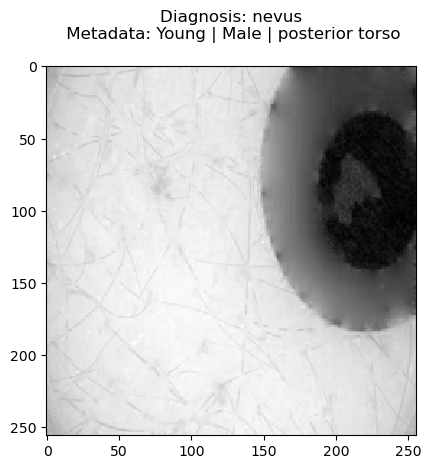

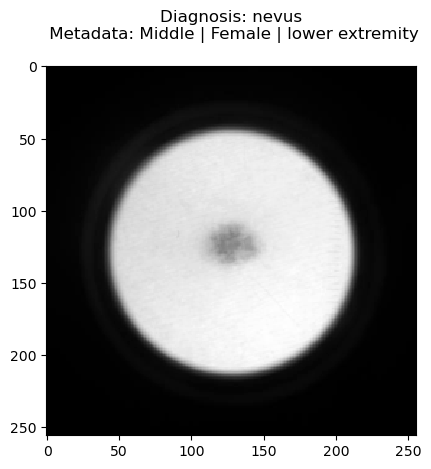

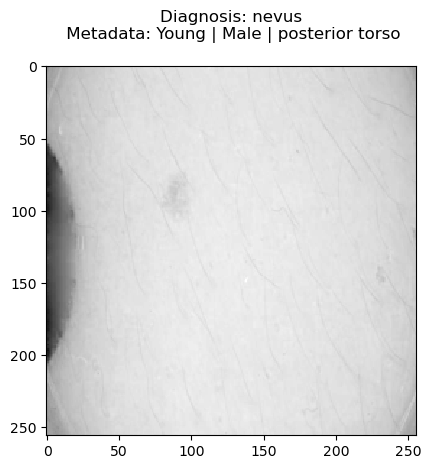

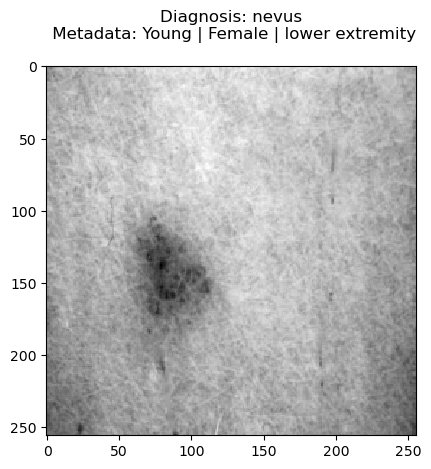

In [12]:
age = ['Young', 'Middle', 'Elderly', 'Senile']
sex = ['Male', 'Female']
anatomloc = ['anterior torso', 'head/neck', 'lateral torso', 'lower extremity', 'oral/genital', 'palms/soles', 'posterior torso', 'upper extremity']


examples = enumerate(testloader)
batch_idx, (example_data, example_meta, example_targets) = next(examples)

for i in range(4):
    fig = plt.figure()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    age1 = torch.tensor(example_meta[i][0], dtype=torch.long)
    sex1 = torch.tensor(example_meta[i][1], dtype=torch.long)
    anatomloc1 = torch.tensor(example_meta[i][2], dtype=torch.long)
    plt.title("Diagnosis: {}\n Metadata: {} | {} | {}\n".format(label2[example_targets[i]], age[age1], sex[sex1], anatomloc[anatomloc1]))

In [13]:
import timm

inception_v4 = timm.create_model('inception_v4', pretrained=True)
inception_v4.last_linear = nn.Linear(in_features=1536, out_features=num_classes)

class inception(nn.Module):
    def __init__(self):
        super(inception, self).__init__()
        
        self.model = inception_v4
       
        self.meta_net = nn.Sequential(nn.Linear(3, 64),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(64),
                                      nn.Linear(64, 32),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(32),
                                      nn.Linear(32, 32),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(32),
                                      nn.Linear(32, 10))
        
        self.out = nn.Linear(10+10, 10)
                
    def forward(self, img , tab):
        
        img = self.model(img) 
        img = img.reshape(img.shape[0], -1)
        
        tab = self.meta_net(tab)
        
        x = torch.cat((img, tab),1)
        x = self.out(x)
        
        return x

model = inception()
model = model.to(device)

model

inception(
  (model): InceptionV4(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2

In [14]:
model_name = 'C:\\Users\\...\\inception.pt'

model_weights = torch.load(model_name, device)
model.load_state_dict(model_weights)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) 
criterion = nn.CrossEntropyLoss().to(device)

In [15]:
actuals = []
predictions = []
    
with torch.no_grad():
    
    for data in testloader:
        image, feats, label = data
        image, feats, label = image.to(device), feats.to(device), label.to(device)
            
        output = model(image, feats)
        
        pred = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()
        
        predictions.extend(pred)
        
        label = label.cpu().data.numpy()
        actuals.extend(label)

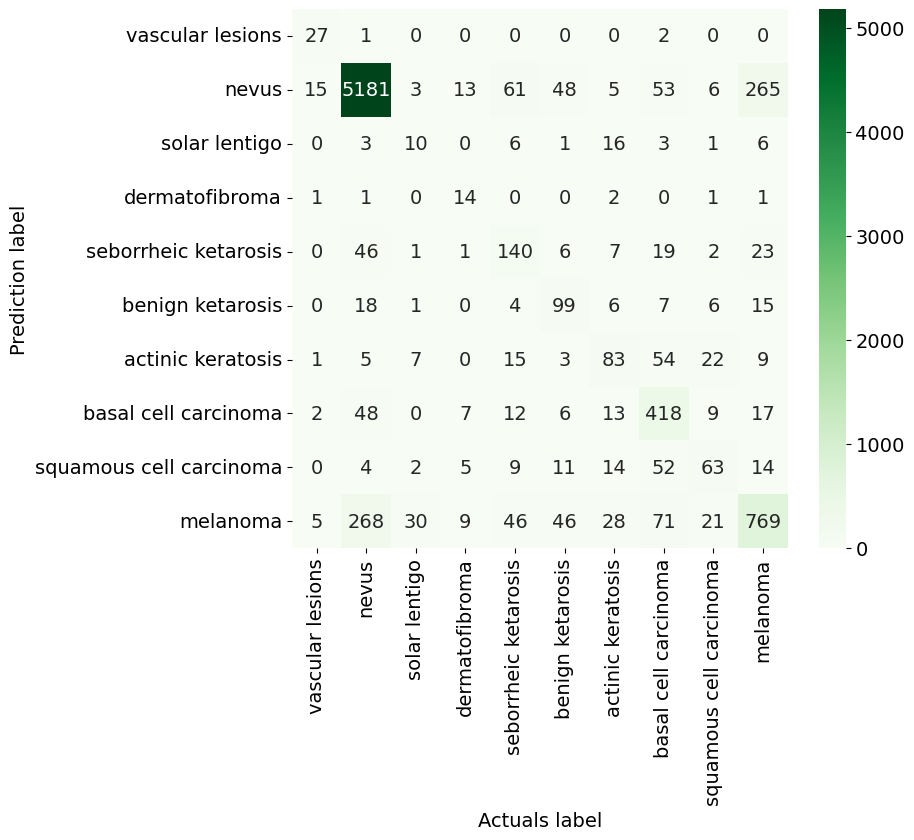

In [16]:
matrix = confusion_matrix(predictions, actuals)

df_matrix = pd.DataFrame(matrix, label2, label2)

plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [17]:
from torchmetrics.classification import MulticlassSpecificity
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

cm = confusion_matrix(actuals, predictions)
FP = np.mean(cm.sum(axis=0) - np.diag(cm))  
FN = np.mean(cm.sum(axis=1) - np.diag(cm))
TP = np.mean(np.diag(cm))
TN = np.mean(cm.sum() - (FP + FN + TP))

Sensitivity = (TP/(TP+FN))
Specificity = (TN/(TN+FP))
Precision = (TP/(TP+FP))
NPV = (TN/(TN+FN))
PPV = (TP/(TP+FP))
FNR = (FN/(FN+TP))
FPR = (FP/(FP+TN))

F1 = (2*TP)/((2*TP)+FP+FN)

print('Sensitivity: %.4f' % Sensitivity)
print('Specificity: %.4f' % Specificity)
print('Precision: %.4f' % Precision)
print('NPV: %.4f' % NPV)
print('PPV: %.4f' % PPV)
print('FNR: %.4f' % FNR)
print('FPR: %.4f' % FPR)
print('F1: %.4f' % F1)

# recall_score = tp / (tp + fn)

recall_1 = recall_score(actuals, predictions, average='micro')
print('Recall micro: %.f' % recall_1)
recall_2 = recall_score(actuals, predictions, average='macro')
print('Recall macro: %.4f' % recall_2)

# precision_score = tp / (tp + fp)

precision_1 = precision_score(actuals, predictions, average='micro')
print('Precision micro: %.4f' % precision_1)
precision_2 = precision_score(actuals, predictions, average='macro')
print('Precision macro: %.4f' % precision_2)

# F1 = 2 * (precision * recall) / (precision + recall)

f1_1 = f1_score(actuals, predictions, average='micro')
print('F1 score micro: %.4f' % f1_1)
f1_2 = f1_score(actuals, predictions, average='macro')
print('F1 score macro: %.4f' % f1_2)

jaccard_1 = jaccard_score(actuals, predictions, average='micro')
print('Jaccard score micro: %.4f' % jaccard_1)
jaccard_2 = jaccard_score(actuals, predictions, average='macro')
print('Jaccard score macro: %.4f' % jaccard_2)

accuracy_1 = accuracy_score(actuals, predictions)
print('Accuracy score: %.4f' % accuracy_1)

MCC = matthews_corrcoef(actuals, predictions)
print('Matthews corrcoef: %.4f' % MCC)

pre = torch.tensor(predictions)
ac = torch.tensor(actuals)

# Specificity = tn / tn + fp

specificity1 = MulticlassSpecificity(average='macro', num_classes=10)
s1 = specificity1(pre, ac)
print('Specificity macro: %.4f' % s1)

specificity2 = MulticlassSpecificity(average='micro', num_classes=10)
s2 = specificity2(pre, ac)
print('Specificity micro: %.4f' % s2)

specificity3 = MulticlassSpecificity(average='weighted', num_classes=10)
s3 = specificity3(pre, ac)
print('Specificity weighted: %.4f' % s3)

specificity4 = MulticlassSpecificity(average='none', num_classes=10)
s4 = specificity4(pre, ac)
print('Specificity none - class vascular lesions (0): %.4f' % s4[0])
print('Specificity none - class nevus (1): %.4f' % s4[1])
print('Specificity none - class solar lentigo (2): %.4f' % s4[2])
print('Specificity none - class dermatofibroma (3): %.4f' % s4[3])
print('Specificity none - class seborrheic ketarosis (4): %.4f' % s4[4])
print('Specificity none - class benign ketarosis (5): %.4f' % s4[5])
print('Specificity none - class actinic keratosis (6): %.4f' % s4[6])
print('Specificity none - class basal cell carcinoma (7): %.4f' % s4[7])
print('Specificity none - class squamous cell carcinoma (8): %.4f' % s4[8])
print('Specificity none - class melanoma (9): %.4f' % s4[9])

Sensitivity: 0.8153
Specificity: 0.9795
Precision: 0.8153
NPV: 0.9795
PPV: 0.8153
FNR: 0.1847
FPR: 0.0205
F1: 0.8153
Recall micro: 1
Recall macro: 0.5118
Precision micro: 0.8153
Precision macro: 0.6100
F1 score micro: 0.8153
F1 score macro: 0.5429
Jaccard score micro: 0.6882
Jaccard score macro: 0.3974
Accuracy score: 0.8153
Matthews corrcoef: 0.6451
Specificity macro: 0.9690
Specificity micro: 0.9795
Specificity weighted: 0.8748
Specificity none - class vascular lesions (0): 0.9996
Specificity none - class nevus (1): 0.8307
Specificity none - class solar lentigo (2): 0.9957
Specificity none - class dermatofibroma (3): 0.9993
Specificity none - class seborrheic ketarosis (4): 0.9870
Specificity none - class benign ketarosis (5): 0.9930
Specificity none - class actinic keratosis (6): 0.9858
Specificity none - class basal cell carcinoma (7): 0.9851
Specificity none - class squamous cell carcinoma (8): 0.9865
Specificity none - class melanoma (9): 0.9275


In [18]:
def binar_matrix (matrix):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(6):
        matrixTP = matrix[i][:6]
        matrixFP = matrix[i][6:]
        for number in matrixTP:
            TP += number
        for number in matrixFP:
            FP += number
    for i in range(4):
        matrixFN = matrix[i+6][:6]
        matrixTN = matrix[i+6][6:]
        for number in matrixFN:
            FN += number
        for number in matrixTN:
            TN += number
    return TP, TN, FP, FN

TP, TN, FP, FN  = binar_matrix(matrix)

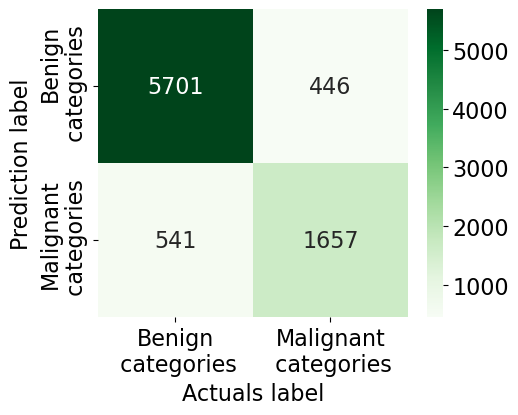

In [19]:
binar_data = [[TP, FP], [FN, TN]]
binarmatrix = torch.tensor(binar_data)

categories = ['Benign\n categories', 'Malignant\n categories']

df_matrix = pd.DataFrame(binarmatrix, categories, categories)
plt.rcParams['font.size'] = '16'

plt.figure(figsize = (5,4))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [20]:
from math import sqrt

Sensitivity = (TP / (TP + FN))
Specificity = (TN / (TN + FP))

Precision = (TP / (TP + FP))

NPV = (TN / (TN + FN))
PPV = (TP / (TP + FP))
FNR = (FN / (FN + TP))
FPR = (FP / (FP + TN))

F1 = (2 * TP) / ((2 * TP) + FP + FN)

Acc = (TP + TN) / (TP + TN + FP + FN)

def mcc(TP, FP, TN, FN):
    x1 = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)
    x2 = ((TP * TN) - (FP * FN)) / sqrt(x1)
    return x2

MCC = mcc(TP, FP, TN, FN)

print('Onco Sensitivity: %.4f' % Sensitivity)
print('Onco Specificity: %.4f' % Specificity)
print('\nOnco Accuracy: %.4f' % Acc)
print('Onco F1: %.4f' % F1)
print('Onco Matthews corrcoef: %.4f' % MCC)
print('\nOnco FNR: %.4f' % FNR)
print('Onco FPR: %.4f' % FPR)
print('Onco NPV: %.4f' % NPV)
print('Onco PPV: %.4f' % PPV)

Onco Sensitivity: 0.9133
Onco Specificity: 0.7879

Onco Accuracy: 0.8817
Onco F1: 0.9203
Onco Matthews corrcoef: 0.6912

Onco FNR: 0.0867
Onco FPR: 0.2121
Onco NPV: 0.7539
Onco PPV: 0.9274


In [21]:
class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, use_cache = False, transform = None):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.inputs_dtype = torch.float32
        
        self.transform = transform
        
        self.use_cache = use_cache
        
        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.path_imgs)), desc='Caching')
            for i, img in zip(progressbar, self.path_imgs):
                img = Image.open(img)
                if self.transform is not None:
                    img= self.transform(img)
                
                self.cached_data.append(img)
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.cached_data[idx]

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)

        return img, feats, label

def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [22]:
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, y):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Error')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [23]:
data_dir = "C:\\Users\\...\\DATASET\\"
metadata = pd.read_csv('C:\\Users\\...\\MetaData.csv')

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:\\Users\\...\\DATASET\\*.jpg'), key=numericalSort)

labels_cat = ['0. vascular lesions', '1. nevus', '2. solar lentigo', '3. dermatofibroma', '4. seborrheic ketarosis', '5. benign ketarosis', '6. actinic keratosis', '7. basal cell carcinoma', '8. squamous cell carcinoma', '9. melanoma']

    #CPU или GPU
device = get_default_device()

In [ ]:
model_name = 'C:\\Users\\...\\inception_weights.pt'

model_weights = torch.load(model_name, device)
model.load_state_dict(model_weights)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) 
criterion = nn.CrossEntropyLoss(weight=weight).to(device)

In [29]:
actuals = []
predictions = []
    
with torch.no_grad():
    
    for data in testloader:
        image, feats, label = data
        image, feats, label = image.to(device), feats.to(device), label.to(device)
            
        output = model(image, feats)
        
        pred = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()
        
        predictions.extend(pred)
        
        label = label.cpu().data.numpy()
        actuals.extend(label)

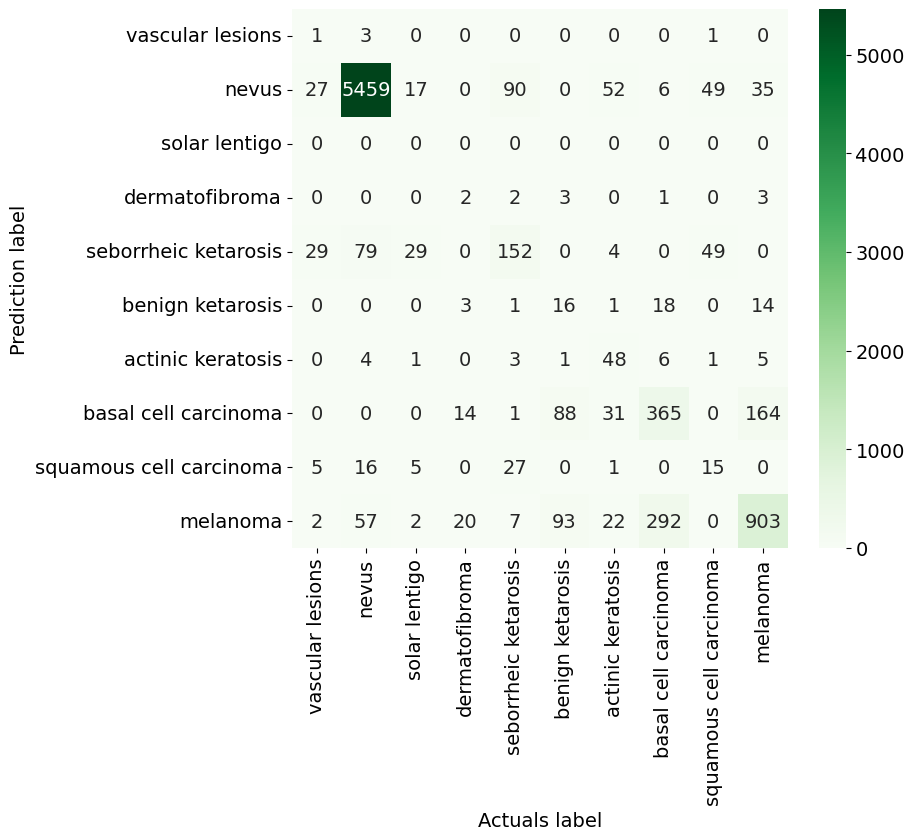

In [30]:
matrix = confusion_matrix(predictions, actuals)

df_matrix = pd.DataFrame(matrix, label2, label2)

plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [31]:
cm = confusion_matrix(actuals, predictions)
FP = np.mean(cm.sum(axis=0) - np.diag(cm))  
FN = np.mean(cm.sum(axis=1) - np.diag(cm))
TP = np.mean(np.diag(cm))
TN = np.mean(cm.sum() - (FP + FN + TP))

Sensitivity = (TP/(TP+FN))
Specificity = (TN/(TN+FP))
Precision = (TP/(TP+FP))
NPV = (TN/(TN+FN))
PPV = (TP/(TP+FP))
FNR = (FN/(FN+TP))
FPR = (FP/(FP+TN))

F1 = (2*TP)/((2*TP)+FP+FN)

print('Sensitivity: %.4f' % Sensitivity)
print('Specificity: %.4f' % Specificity)
print('Precision: %.4f' % Precision)
print('NPV: %.4f' % NPV)
print('PPV: %.4f' % PPV)
print('FNR: %.4f' % FNR)
print('FPR: %.4f' % FPR)
print('F1: %.4f' % F1)

# recall_score = tp / (tp + fn)

recall_1 = recall_score(actuals, predictions, average='micro')
print('Recall micro: %.f' % recall_1)
recall_2 = recall_score(actuals, predictions, average='macro')
print('Recall macro: %.4f' % recall_2)

# precision_score = tp / (tp + fp)

precision_1 = precision_score(actuals, predictions, average='micro')
print('Precision micro: %.4f' % precision_1)
precision_2 = precision_score(actuals, predictions, average='macro')
print('Precision macro: %.4f' % precision_2)

# F1 = 2 * (precision * recall) / (precision + recall)

f1_1 = f1_score(actuals, predictions, average='micro')
print('F1 score micro: %.4f' % f1_1)
f1_2 = f1_score(actuals, predictions, average='macro')
print('F1 score macro: %.4f' % f1_2)

jaccard_1 = jaccard_score(actuals, predictions, average='micro')
print('Jaccard score micro: %.4f' % jaccard_1)
jaccard_2 = jaccard_score(actuals, predictions, average='macro')
print('Jaccard score macro: %.4f' % jaccard_2)

accuracy_1 = accuracy_score(actuals, predictions)
print('Accuracy score: %.4f' % accuracy_1)

MCC = matthews_corrcoef(actuals, predictions)
print('Matthews corrcoef: %.4f' % MCC)

pre = torch.tensor(predictions)
ac = torch.tensor(actuals)

# Specificity = tn / tn + fp

specificity1 = MulticlassSpecificity(average='macro', num_classes=10)
s1 = specificity1(pre, ac)
print('Specificity macro: %.4f' % s1)

specificity2 = MulticlassSpecificity(average='micro', num_classes=10)
s2 = specificity2(pre, ac)
print('Specificity micro: %.4f' % s2)

specificity3 = MulticlassSpecificity(average='weighted', num_classes=10)
s3 = specificity3(pre, ac)
print('Specificity weighted: %.4f' % s3)

specificity4 = MulticlassSpecificity(average='none', num_classes=10)
s4 = specificity4(pre, ac)
print('Specificity none - class vascular lesions (0): %.4f' % s4[0])
print('Specificity none - class nevus (1): %.4f' % s4[1])
print('Specificity none - class solar lentigo (2): %.4f' % s4[2])
print('Specificity none - class dermatofibroma (3): %.4f' % s4[3])
print('Specificity none - class seborrheic ketarosis (4): %.4f' % s4[4])
print('Specificity none - class benign ketarosis (5): %.4f' % s4[5])
print('Specificity none - class actinic keratosis (6): %.4f' % s4[6])
print('Specificity none - class basal cell carcinoma (7): %.4f' % s4[7])
print('Specificity none - class squamous cell carcinoma (8): %.4f' % s4[8])
print('Specificity none - class melanoma (9): %.4f' % s4[9])

Sensitivity: 0.8342
Specificity: 0.9816
Precision: 0.8342
NPV: 0.9816
PPV: 0.8342
FNR: 0.1658
FPR: 0.0184
F1: 0.8342
Recall micro: 1
Recall macro: 0.3422
Precision micro: 0.8342
Precision macro: 0.4190
F1 score micro: 0.8342
F1 score macro: 0.3524
Jaccard score micro: 0.7155
Jaccard score macro: 0.2655
Accuracy score: 0.8342
Matthews corrcoef: 0.6740
Specificity macro: 0.9753
Specificity micro: 0.9816
Specificity weighted: 0.9184
Specificity none - class vascular lesions (0): 0.9995
Specificity none - class nevus (1): 0.8988
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 0.9989
Specificity none - class seborrheic ketarosis (4): 0.9764
Specificity none - class benign ketarosis (5): 0.9955
Specificity none - class actinic keratosis (6): 0.9974
Specificity none - class basal cell carcinoma (7): 0.9611
Specificity none - class squamous cell carcinoma (8): 0.9934
Specificity none - class melanoma (9): 0.9314


C:\Users\uljah\anaconda3\envs\NeuralNetw38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def binar_matrix (matrix):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(6):
        matrixTP = matrix[i][:6]
        matrixFP = matrix[i][6:]
        for number in matrixTP:
            TP += number
        for number in matrixFP:
            FP += number
    for i in range(4):
        matrixFN = matrix[i+6][:6]
        matrixTN = matrix[i+6][6:]
        for number in matrixFN:
            FN += number
        for number in matrixTN:
            TN += number
    return TP, TN, FP, FN

TP, TN, FP, FN  = binar_matrix(matrix)

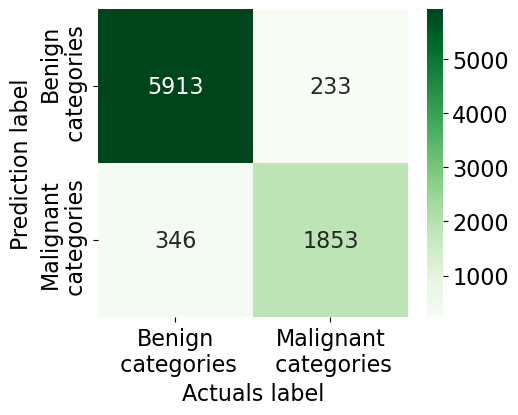

In [33]:
binar_data = [[TP, FP], [FN, TN]]
binarmatrix = torch.tensor(binar_data)

categories = ['Benign\n categories', 'Malignant\n categories']

#matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(binarmatrix, categories, categories)
plt.rcParams['font.size'] = '16'

plt.figure(figsize = (5,4))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [34]:
Sensitivity = (TP / (TP + FN))
Specificity = (TN / (TN + FP))

Precision = (TP / (TP + FP))

NPV = (TN / (TN + FN))
PPV = (TP / (TP + FP))
FNR = (FN / (FN + TP))
FPR = (FP / (FP + TN))

F1 = (2 * TP) / ((2 * TP) + FP + FN)

Acc = (TP + TN) / (TP + TN + FP + FN)

def mcc(TP, FP, TN, FN):
    x1 = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)
    x2 = ((TP * TN) - (FP * FN)) / sqrt(x1)
    return x2

MCC = mcc(TP, FP, TN, FN)

print('Onco Sensitivity: %.4f' % Sensitivity)
print('Onco Specificity: %.4f' % Specificity)
print('\nOnco Accuracy: %.4f' % Acc)
print('Onco F1: %.4f' % F1)
print('Onco Matthews corrcoef: %.4f' % MCC)
print('\nOnco FNR: %.4f' % FNR)
print('Onco FPR: %.4f' % FPR)
print('Onco NPV: %.4f' % NPV)
print('Onco PPV: %.4f' % PPV)

Onco Sensitivity: 0.9447
Onco Specificity: 0.8883

Onco Accuracy: 0.9306
Onco F1: 0.9533
Onco Matthews corrcoef: 0.8188

Onco FNR: 0.0553
Onco FPR: 0.1117
Onco NPV: 0.8427
Onco PPV: 0.9621
